In [1]:
import datacube
import geopandas as gpd
import odc.geo.xr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colormaps
from matplotlib.patches import Patch

from pathlib import Path

import numpy as np
from scipy.stats import gaussian_kde

from dea_tools.spatial import xr_rasterize

from tqdm.auto import tqdm

import gc

import warnings
warnings.filterwarnings("ignore")

In [2]:
# --- global font ---
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size']   = 12


def nas_patch(http_url):
    url = http_url.replace(
        "/nas-rs.topo.auth.gr", "////nas-rs.topo.auth.gr"
    ).rstrip(":1")
    return url

In [3]:
dc = datacube.Datacube(app='basecomp', env='drought')

In [4]:
dc.list_products()

,name,description,license,default_crs,default_resolution
name,,,,,
baseline,baseline,Mean and Standard deviation of time series fro...,CC-BY-4.0,EPSG:3035,"Resolution(x=20, y=-20)"
composites,composites,Monthly median S2L2A composites from Microsoft...,CC-BY-4.0,EPSG:3035,"Resolution(x=20, y=-20)"
copdem,copdem,Copernicus DEM,CC-BY-4.0,EPSG:3035,"Resolution(x=20, y=-20)"
tcd2023,tcd2023,Tree Density Cover 2023,CC-BY-4.0,EPSG:3035,"Resolution(x=10, y=-10)"
z_normalized,z_normalized,"Z-Normalized NDVI, EVI, PSRI2 time series from...",CC-BY-4.0,EPSG:3035,"Resolution(x=20, y=-20)"


In [5]:
forestlife_habitats = gpd.read_file(
    '../anciliary/Natura2000_habitats2018.shp'
).to_crs(epsg=3035)


agg = {
    "SPEC_DOM1": lambda s: list(s.dropna().unique()),
    "SPEC_DOM2": lambda s: list(s.dropna().unique()),
    "HABNAME1": "first",
    "SPECIES": lambda x: ", ".join(sorted(set(x.dropna()))),
    "OBJECTID_1": "count",        # how many polygons merged
    "AREA": "sum",                # original area units, if available
    # add other attributes as needed
}

forestlife_habitats_dissolved = forestlife_habitats.dissolve(
    by="SITECODE",
    aggfunc=agg,
    as_index=False
)

forestlife_habitats_dissolved['AREA'] = forestlife_habitats_dissolved.geometry.area

In [6]:
SITECODE = 'GR2220002'
zone_gdf = forestlife_habitats_dissolved[forestlife_habitats_dissolved['SITECODE'] == SITECODE]

zone = zone_gdf.iloc[0]
zone_title = f"{zone['SITECODE']}"
xmin, ymin, xmax, ymax = zone.geometry.bounds

In [9]:
spectral_index = 'PSRI2'
si_znorm = f'{spectral_index}_z'

ds_zorm = dc.load(
    product='z_normalized',
    measurements=si_znorm,
    x=(xmin, xmax),
    y=(ymin, ymax),
    crs='EPSG:3035',
    patch_url=nas_patch
)[si_znorm]

In [10]:
ds_zorm.isel(x=170, y=538//2).plot.scatter(x='time')

In [9]:
ds_tcd = dc.load(
    product='tcd2023',
    like=ds_zorm.odc.geobox,
    patch_url=nas_patch
).squeeze()

In [10]:
ds_dem = dc.load(
    product='copdem',
    like=ds_zorm.odc.geobox,
    measurements='aspect',
    patch_url=nas_patch
).squeeze()

In [11]:
zone_mask = xr_rasterize(zone_gdf, da=ds_zorm)

In [12]:
canopy30_mask = (ds_tcd.tcd >= 30).fillna(0).astype("uint8")

In [13]:
analysis_mask = ((canopy30_mask == 1) & (zone_mask == 1)).astype("uint8")

In [14]:
analysis_mask.plot()

In [98]:
ds_zorm_masked = ds_zorm.where(analysis_mask)

In [103]:
ds_zorm_masked.isel(x=170, y=538//2)

<xarray.DataArray 'EVI_z' (time: 32)> Size: 128B
array([3.6367188, 3.5253906, 3.4824219, 3.5410156, 3.6230469, 4.0234375,
       4.8085938, 5.1484375, 5.2382812, 5.0898438, 4.9921875, 3.7929688,
       3.5253906, 3.4003906, 3.0820312, 3.1621094, 3.4003906, 4.5390625,
       4.84375  , 5.2890625, 4.875    , 3.9921875, 4.9648438, 4.15625  ,
       3.5859375, 3.3554688, 3.2890625, 3.3261719, 3.4140625, 4.3320312,
       4.8828125, 5.2382812], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 256B 2023-04-01 2023-05-01 ... 2025-11-01
    y            float64 8B 1.74e+06
    x            float64 8B 5.256e+06
    spatial_ref  int32 4B 3035
Attributes:
    units:         1
    nodata:        nan
    crs:           EPSG:3035
    grid_mapping:  spatial_ref

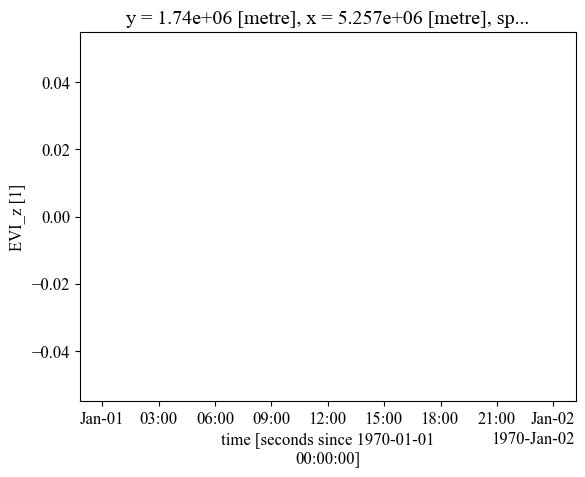

In [99]:
ds_zorm_masked.isel(x=468//2, y=538//2).plot.scatter(x='time')